In [25]:
import os
import re

import numpy as np
import tensorflow as tf

from quanteyes.dataloader.dataset_tf import get_zipped_dataset
from quanteyes.training_tf.utils import DATA_PATHS

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from PIL import Image

In [26]:
path = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction-2bit-octree/'

val_dataset = get_zipped_dataset(
	f"{path}/validation", train=False
).shuffle(1000)

In [27]:
tf_model_path = '../../model_export/q-int8_d-2bit-octree.tflite'

interpreter = tf.lite.Interpreter(model_path=tf_model_path)
interpreter.allocate_tensors()

In [28]:
# Get input and output tensors
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

input_tensor_index = input_details["index"]
output = interpreter.get_tensor(output_details["index"])

mse = 0.0
avg_cosine_similarity = 0.0
num_examples = 100
it = iter(val_dataset.batch(1).take(num_examples))

In [50]:
input_data, target = it.next()
img_array = input_data.numpy()

[[ -97 -114   92]] [ -97 -114   92]
[-0.09903552 -0.16637969  0.64967304] [ 0.185303   -0.00600103  0.9826631 ]
tf.Tensor(0.91613096, shape=(), dtype=float32)


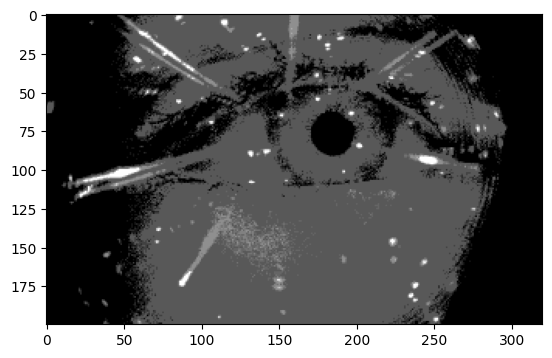

In [53]:
input_data, target = it.next()
img_array = input_data.numpy()

save_img = (img_array / np.max(img_array) * 255)[0, :, :, 0].astype(np.uint8)
plt.imshow(save_img, cmap='gray')
Image.fromarray(save_img).save('test.png')
# print(img_array[0, :, :, 0].shape)

input_scale, input_zero_point = input_details["quantization"]
if (input_scale, input_zero_point) != (0.0, 0):
	img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
img_array = img_array.astype(input_details["dtype"])

interpreter.set_tensor(input_tensor_index, img_array)
interpreter.invoke()
pred = output[0]

print(output, pred)

# If required, dequantized the output layer (from integer to float)
output_scale, output_zero_point = output_details["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
	pred = pred.astype(np.float32)
	pred = np.multiply((pred - output_zero_point), output_scale)

# Compute cosine similarity.
y_pred = pred.astype(np.float32)
y_true = np.squeeze(target.numpy().T).astype(np.float32)

cosine_siimilarity = -1 * tf.keras.losses.cosine_similarity(
	y_true, y_pred
)
print(y_pred, y_true)
print(cosine_siimilarity)

avg_cosine_similarity += cosine_siimilarity

unit_vector_pred = y_pred / np.linalg.norm(y_pred)
unit_vector_true = y_true / np.linalg.norm(y_true)
df = {
	'x': [0, unit_vector_pred[0], 0, unit_vector_true[0]],
	'y': [0, unit_vector_pred[1], 0, unit_vector_true[1]],
	'z': [0, unit_vector_pred[2], 0, unit_vector_true[2]],
	'color': ['red', 'red', 'blue', 'blue'],
	'label': ['pred', 'pred', 'true', 'true']
}

df = pd.DataFrame(df)

fig = px.line_3d(df, x="x", y="y", z="z", color='color', labels='label')

fig.update_layout(
	width=700,
	height=300,
	margin=dict(r=20, l=10, b=10, t=10)
)

fig.show()